In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
        
    def __rmul__(self, other):
        return self * other

    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')
        def _backward():
            self.grad += math.exp(self.data) * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return -1 * self

    def __sub__(self, other):
        return self + (-other)

    def __pow__(self, other):
        out = Value(self.data**other, (self, ), f"**{other}")
        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        for n in reversed(topo):
            n._backward()

In [6]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'})
    
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for (n1, n2) in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

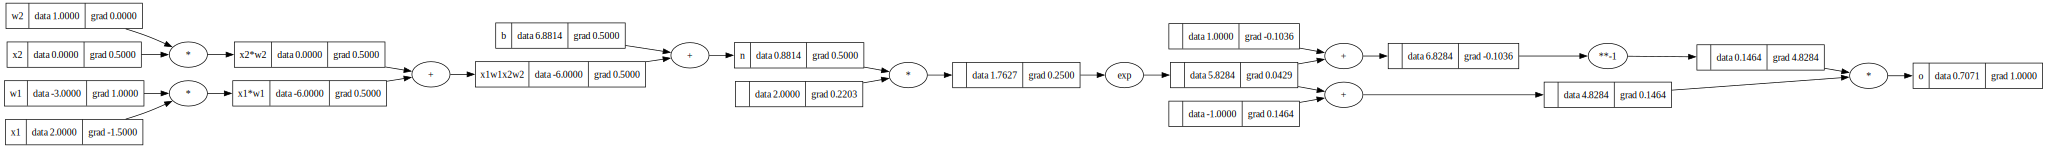

In [7]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2 (synaptic strings for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
# cell body raw activation without the activation function (tanh)
n = x1w1x2w2 + b; n.label='n'
# --- 
e = (2*n).exp()
o = (e - 1) / (e + 1)
#o = n.tanh(); o.label = 'o' 
# ----
o.label = 'o'
o.backward()

draw_dot(o)